In [42]:
import functools
import gymnasium as gym
import seaborn as sns
from stable_baselines3 import PPO
import torch
import numpy as np
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import SubprocVecEnv
import os
import multiprocessing
from enum import Enum
import json
import wandb
from datetime import datetime
from torch import FloatTensor
from torch.utils.data import DataLoader
import shutil
from models.gail import GAIL
from generate_expert_data import collect_expert_data, postprocess
from forward_simulation import make_configure_env, append_key_to_dict_of_dict, simulate_with_model
from sb3_callbacks import CustomCheckpointCallback, CustomMetricsCallback, CustomCurriculamCallback
from utilities import extract_post_processed_expert_data, write_module_hierarchy_to_file, DefaultActorCriticPolicy, CustomDataset, CustomExtractor, retrieve_gail_agents
import warnings
from imitation.algorithms import bc
from python_config import sweep_config, env_kwargs
import matplotlib.pyplot as plt
import zipfile
from imitation.algorithms import bc
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [43]:
warnings.filterwarnings("ignore")

from highway_env.envs.common.action import DiscreteMetaAction
ACTIONS_ALL = DiscreteMetaAction.ACTIONS_ALL


class TrainEnum(Enum):
    RLTRAIN = 0
    RLDEPLOY = 1
    IRLTRAIN = 2
    IRLDEPLOY = 3
    EXPERT_DATA_COLLECTION =4
    BC = 5
    BCDEPLOY = 6

train = TrainEnum.BC



attention_network_kwargs = dict(
    # in_size=5*15,
    embedding_layer_kwargs={"in_size": 7, "layer_sizes": [64, 64], "reshape": False},
    attention_layer_kwargs={"feature_size": 64, "heads": 2},
    # num_layers = 3,
)

def timenow():
    return datetime.now().strftime("%H%M")

# ==================================
#        Main script  20 
# ==================================


In [44]:
policy_kwargs = dict(
        features_extractor_class=CustomExtractor,
        features_extractor_kwargs=attention_network_kwargs,
    )

if False:
    optimal_gail_agent, final_gail_agent = retrieve_gail_agents(
                                                                # env= make_configure_env(**env_kwargs).unwrapped, # need only certain parameters
                                                                artifact_version='trained_model_directory:v2'
                                                                )
    reward_oracle = final_gail_agent.d
    env_kwargs.update({'reward_oracle':reward_oracle})

WARM_START = False
# Get the current date and time
now = datetime.now()
month = now.strftime("%m")
day = now.strftime("%d")
expert_data_file='expert_data_relative.h5'
validation_data_file = 'expert_data_rel_val.h5'
zip_filename = '../expert_data.zip'
n_cpu =  multiprocessing.cpu_count()
device = torch.device("cpu")
extract_path = "../data/expert_data"

In [45]:
!pwd

/home/ubuntu/HighwayEnv/scripts


# Assuming a zip file containing train data files and validaiton data files
# populate hyper parameters and config params, say prepare experiment
# Extract Datasets
# Load Dataloaders
# Create Trainer
# Train data for n epochs
# Validate data

In [46]:
def create_trainer(env, policy, **kwargs):
    return       bc.BC(
                        observation_space=env.observation_space,
                        action_space=env.action_space,
                        demonstrations=None, #training_transitions,
                        rng=np.random.default_rng(),
                        batch_size=kwargs['batch_size'],
                        device = device,
                        policy=policy
                        )

In [47]:
def create_dataloaders(zip_filename, **kwargs):
    # Extract the HDF5 files from the zip archive
    with zipfile.ZipFile(zip_filename, 'r') as archive:
        archive.extractall(extract_path)

    # Extract the names of the HDF5 files from the zip archive
    with zipfile.ZipFile(zip_filename, 'r') as archive:
        hdf5_train_file_names = [os.path.join(extract_path, name) 
                                    for name in archive.namelist() 
                                    if name.endswith('.h5') and "train" in name]
        hdf5_val_file_names = [os.path.join(extract_path, name) 
                                    for name in archive.namelist() 
                                    if name.endswith('.h5') and "val" in name]            

    # Create separate datasets for each HDF5 file
    train_datasets = [CustomDataset(hdf5_name, device) for hdf5_name in hdf5_train_file_names]
    # val_datasets = [CustomDataset(hdf5_name, device) for hdf5_name in hdf5_val_file_names]
    
    # custom_dataset = CustomDataset(expert_data_file, device=device)
    train_data_loaders = [DataLoader(
                                dataset, 
                                batch_size=kwargs['batch_size'], 
                                shuffle=True,
                                drop_last=True,
                                num_workers=n_cpu,
                                pin_memory=True
                            ) for dataset in train_datasets]
    return train_data_loaders, hdf5_train_file_names, hdf5_val_file_names


In [48]:
def _train(trainer, data_loaders, **training_kwargs):
    for epoch in range(training_kwargs['num_epochs']):
        for data_loader in data_loaders:
            trainer.set_demonstrations(data_loader)
            trainer.train(n_epochs=1)

In [49]:
def calculate_validation_metrics(bc_trainer, hdf5_train_file_names, hdf5_val_file_names, **training_kwargs):
    true_labels = []
    predicted_labels = []
    # Iterate through the validation data and make predictions
    with torch.no_grad():
        for val_data_file in hdf5_val_file_names:
            val_obs, val_acts, val_dones = extract_post_processed_expert_data(val_data_file)
            predicted_labels.extend([bc_trainer.policy.predict(obs)[0] for obs in val_obs])
            true_labels.extend(val_acts)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    f1 = f1_score(true_labels, predicted_labels, average=None)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Print the metrics
    print("Accuracy:", accuracy, np.mean(accuracy))
    print("Precision:", precision, np.mean(precision))
    print("Recall:", recall, np.mean(recall))
    print("F1 Score:", f1, np.mean(f1))


    predicted_labels = []
    true_labels = []
    with torch.no_grad():
        for val_data_file in hdf5_train_file_names:
            val_obs, val_acts, val_dones = extract_post_processed_expert_data(val_data_file)
            predicted_labels.extend([bc_trainer.policy.predict(obs)[0] for obs in val_obs])
            true_labels.extend(val_acts)

    # Calculate evaluation metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    f1 = f1_score(true_labels, predicted_labels, average=None)



    print("--------  Training data metrics for reference---------------")
    print("Accuracy:", accuracy, np.mean(accuracy))
    print("Precision:", precision,  np.mean(precision))
    print("Recall:", recall, np.mean(recall))
    print("F1 Score:", f1, np.mean(recall))


    plt.figure(figsize=(8, 6))
    class_labels = [ ACTIONS_ALL[idx] for idx in range(len(ACTIONS_ALL))]
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()    

    plt.savefig(training_kwargs['plot_path'])

In [56]:
from python_config import sweep_config
sweep_config = {
    "method": "grid",
    "metric": {
        "name": "episode_reward",
        "goal": "maximize"
    },
    "parameters": {
        "duration": {
            "values": [40]  # Values for the "duration" field to be swept
        },
        "gae_gamma": {
            "values": [0.995]  # Values for the "duration" field to be swept
        }, 
        "discrm_lr": {
            "values": [0.001]  # Values for the "duration" field to be swept
        },              
        "batch_size": {
            "values": [32, 64, 128]  # Values for the "duration" field to be swept
        }, 
        "num_epochs": {
            "values": [10, 25, 50]  # Values for the "duration" field to be swept
        },    
    }
}
print(sweep_config)

{'method': 'grid', 'metric': {'name': 'episode_reward', 'goal': 'maximize'}, 'parameters': {'duration': {'values': [40]}, 'gae_gamma': {'values': [0.995]}, 'discrm_lr': {'values': [0.001]}, 'batch_size': {'values': [128]}, 'num_epochs': {'values': [3]}}}


Create sweep with ID: bbd4yq7e
Sweep URL: https://wandb.ai/gpinaki/BC_1/sweeps/bbd4yq7e


wandb: Agent Starting Run: zivoamsz with config:
wandb: 	batch_size: 128
wandb: 	discrm_lr: 0.001
wandb: 	duration: 40
wandb: 	gae_gamma: 0.995
wandb: 	num_epochs: 3
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


config  {'batch_size': 128, 'discrm_lr': 0.001, 'duration': 40, 'gae_gamma': 0.995, 'num_epochs': 3}


0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00161 |
|    entropy        | 1.61     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 129      |
|    loss           | 1.61     |
|    neglogp        | 1.61     |
|    prob_true_act  | 0.2      |
|    samples_so_far | 128      |
--------------------------------


139batch [00:02, 60.95batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00143 |
|    entropy        | 1.43     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 134      |
|    loss           | 1.42     |
|    neglogp        | 1.42     |
|    prob_true_act  | 0.272    |
|    samples_so_far | 128      |
--------------------------------


149batch [00:02, 63.53batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00139 |
|    entropy        | 1.39     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 143      |
|    loss           | 1.33     |
|    neglogp        | 1.33     |
|    prob_true_act  | 0.292    |
|    samples_so_far | 128      |
--------------------------------


139batch [00:02, 60.79batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00128 |
|    entropy        | 1.28     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 166      |
|    loss           | 1.07     |
|    neglogp        | 1.08     |
|    prob_true_act  | 0.363    |
|    samples_so_far | 128      |
--------------------------------


149batch [00:02, 64.02batch/s]]
0batch [00:00, ?batch/s]

--------------------------------
| batch_size        | 128      |
| bc/               |          |
|    batch          | 0        |
|    ent_loss       | -0.00106 |
|    entropy        | 1.06     |
|    epoch          | 0        |
|    l2_loss        | 0        |
|    l2_norm        | 193      |
|    loss           | 0.894    |
|    neglogp        | 0.895    |
|    prob_true_act  | 0.437    |
|    samples_so_far | 128      |
--------------------------------


139batch [00:02, 59.59batch/s]]
0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 128       |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000998 |
|    entropy        | 0.998     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 207       |
|    loss           | 0.943     |
|    neglogp        | 0.944     |
|    prob_true_act  | 0.432     |
|    samples_so_far | 128       |
---------------------------------


149batch [00:02, 64.16batch/s]]


Accuracy: 0.47253333333333336 0.47253333333333336
Precision: [0.84140234 0.51890698 0.826546   0.2798654  0.36904322] 0.5671527880175216
Recall: [0.85423729 0.53167421 0.79190751 0.28877315 0.35312831] 0.563944094554248
F1 Score: [0.84777124 0.52521302 0.80885609 0.2842495  0.3609104 ] 0.565400049932547
--------  Training data metrics for reference---------------
Accuracy: 0.4810023814678502 0.4810023814678502
Precision: [0.81905126 0.50418202 0.8527464  0.3359422  0.37199383] 0.5767831431442441
Recall: [0.8584603  0.52525476 0.79025271 0.30525164 0.37834595] 0.5715130728703569
F1 Score: [0.83829287 0.51450271 0.82031104 0.31986242 0.375143  ] 0.5715130728703569


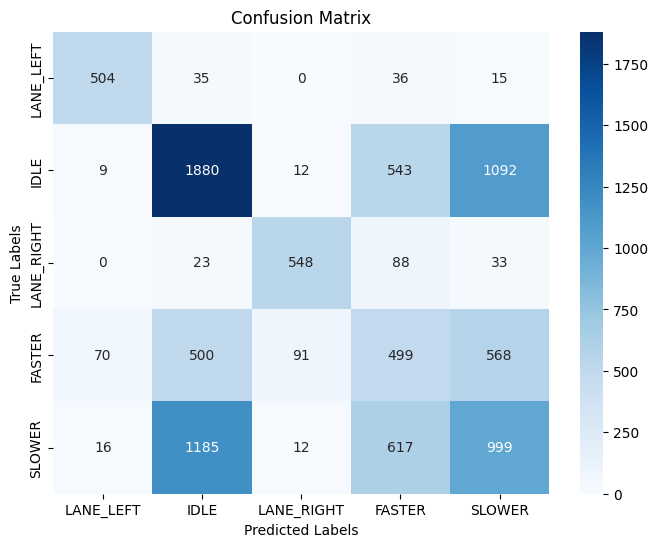

wandb: Adding directory to artifact (./models_archive)... Done. 0.0s


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


<Figure size 640x480 with 0 Axes>

In [58]:
if train == TrainEnum.BC:
    env = make_configure_env(**env_kwargs)
    state_dim = env.observation_space.high.shape[0]*env.observation_space.high.shape[1]
    action_dim = env.action_space.n
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    policy = DefaultActorCriticPolicy(env, device)
    project_name = f"BC_1"

    
    run_name = f"sweep_{month}{day}_{timenow()}"
    sweep_id = wandb.sweep(sweep_config, project=project_name)

    def train_sweep(env, policy, config=None):
        train_kwargs = {
                        "batch_size" : 128,
                        "num_epochs" : 3,
                    }
        with wandb.init(
                            project=project_name, 
                            config=config,
                            # magic=True,
                        ) as run:
            config = run.config
            print("config ", config)
            run.name = f"sweep_{month}{day}_{timenow()}"
            name = ""
            for key, value in config.items():
                # Discard first 3 letters from the key
                key = key[3:]

                # Format the float value
                value_str = "{:.2f}".format(value).rstrip('0').rstrip('.') if value and '.' in str(value) else str(value)

                # Append the formatted key-value pair to the name
                name += f"{key}_{value_str}_"
                # Save the plot as an image
            plot_path = f"plot_{name}.png"    
            train_kwargs['batch_size'] = config.batch_size
            train_kwargs['num_epochs'] = config.num_epochs
            bc_trainer = create_trainer(env, policy, **train_kwargs)
            train_data_loaders, hdf5_train_file_names, hdf5_val_file_names = create_dataloaders(zip_filename, **train_kwargs)
            _train(bc_trainer, train_data_loaders, **train_kwargs)
            calculate_validation_metrics(bc_trainer, hdf5_train_file_names, hdf5_val_file_names, plot_path=plot_path)

            os.makedirs("models_archive", exist_ok=True)
            torch.save(bc_trainer, 'models_archive/BC_agent.pth') 

            # Log the model as an artifact in wandb
            artifact = wandb.Artifact("trained_model_directory", type="model_directory")
            artifact.add_dir("models_archive")
            run.log_artifact(artifact)
            # Log the saved plot to WandB
            # run.log({f"plot_{name}": wandb.Image(plot_path)})
                    


    wandb.agent(
                    sweep_id=sweep_id, 
                    function=lambda: train_sweep(env, policy)
                )

    wandb.finish()
        
